In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/24-fall-sdsc-8007-hw-1/sampleSubmission.csv
/kaggle/input/24-fall-sdsc-8007-hw-1/HW1.test.csv
/kaggle/input/24-fall-sdsc-8007-hw-1/HW1 Data.pdf
/kaggle/input/24-fall-sdsc-8007-hw-1/HW1.train.csv


In [22]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [23]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Truth value')
    plt.ylabel('predicted value')
    plt.title('Truth v.s. Prediction')
    plt.show()

In [24]:
def generate_cross_powered_features(arr0):
    """
    Generates new features by multiplying existing features and then raising the result to the power of 1, 2, 3, and 4.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.

    Returns:
    pd.DataFrame: A new DataFrame with the original features and the newly generated features.
    """
    # Ensure the input array is numeric
    arr0 = arr0.astype(float)
    arr_last = arr0[:,-1:] # for target, not transfer but add after transfer
    arr = arr0[:,:-1]
    # Get the number of original features
    num_features = arr.shape[1]
    
    # Create a list to store the new features
    new_features = []
    
    # Generate new features by multiplication and power operations
    for i in range(num_features):
        for j in range(i + 1, num_features):
            multiplied_feature = arr[:, i] * arr[:, j]
            for power in range(1, 3):
                new_features.append(multiplied_feature ** power)
    
    # Stack the new features horizontally
    new_features_array = np.column_stack(new_features)
    # Concatenate the original array with the new features array
    new_arr = np.hstack((arr, new_features_array))
    new_arr = np.hstack((new_arr, arr_last))
    return new_arr

In [25]:
class Dataprocess(Dataset):
    def __init__(self,
                 path,
                 mode='train',
                 modify=False):
        self.mode = mode

        # Read csv file
        with open(path, 'r') as f:
            data = list(csv.reader(f))
            data = np.array(data[1:])[:, 1:].astype(float) # drop the first row and column
            print(f'origin data_shape is {data.shape}')
#             data = generate_cross_powered_features(data)
            print(f'after generate featured data_shape is {data.shape}')
            print('check the target')
            print(data[:,-1][:5])
#             data = list(csv.reader(f))
#             data = np.array(data[1:])[:, 1:].astype(float)
        
        if modify == False:
            feats = list(range(0,data.shape[1]-1)) # num of features-1
#             feats = list(range(0,93))
            
        else:
            # Hint:Feature Selection
            # Perform feature selection via correlation
            selected_features = select_features_via_correlation(data)
            print(f'Selected Features based on correlation: {selected_features}')
            feats = selected_features    

            # pass

        if mode == 'test':
            # Testing set
            feats = [f+1 for f in feats]
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training set
            target = data[:, -1]
            data = data[:, feats]

            # Splitting data into training and validation sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [26]:
def dataloader(path, mode, batch_size, n_jobs=0, modify=False):
    dataset = Dataprocess(path, mode=mode, modify=modify)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader

In [27]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # Try to modify this DNN to achieve better performance
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),         # Adding batch normalization
            nn.ReLU(),
#             nn.Dropout(0.3),  # Adding dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          # Adding batch normalization
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        

        # Loss function MSE
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, l2_lambda=1e-5):
        ''' Calculate loss with L2 regularization '''
        # Calculate the basic MSE loss
        mse_loss = self.criterion(pred, target)
        
        # Calculate L2 regularization term (weight decay)
#         l2_reg = 0
#         for param in self.parameters():
#             l2_reg += torch.sum(param.pow(2))  # Sum of squared weights
#         mse_loss = mse_loss + l2_lambda * l2_reg
        # Return the total loss: MSE loss + L2 regularization term
        return mse_loss

In [28]:
def train(tr_set, dv_set, model, config, device):

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [29]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [30]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
modify = False                        # Need selection

# Tune these hyper-parameters to improve your model
config = {
    'n_epochs': 2000,                # maximum number of epochs
    'batch_size': 100,               # mini-batch size for dataloader
    'optimizer': 'SGD',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.01               # learning rate of SGD
        #'momentum': 0.9,                # momentum for SGD (only for SGD) default: 0
        #'weight_decay': 1e-5         # L2 regularization (weight decay)
    },
    'early_stop': 100,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [31]:
train_path = '/kaggle/input/24-fall-sdsc-8007-hw-1/HW1.train.csv'  # path to training data
test_path = '/kaggle/input/24-fall-sdsc-8007-hw-1/HW1.test.csv'   # path to testing data

train_set = dataloader(train_path, 'train', config['batch_size'], modify=modify)
validation_set = dataloader(train_path, 'dev', config['batch_size'], modify=modify)
test_set = dataloader(test_path, 'test', config['batch_size'], modify=modify)

origin data_shape is (2000, 94)
after generate featured data_shape is (2000, 94)
check the target
[20.7049346 21.2929114 21.1666563 19.8966066 20.1784284]
Finished reading the train set of COVID19 Dataset (1800 samples found, each dim = 93)
origin data_shape is (2000, 94)
after generate featured data_shape is (2000, 94)
check the target
[20.7049346 21.2929114 21.1666563 19.8966066 20.1784284]
Finished reading the dev set of COVID19 Dataset (200 samples found, each dim = 93)
origin data_shape is (650, 94)
after generate featured data_shape is (650, 94)
check the target
[55.2887607 55.6343707 55.4635486 55.2797177 55.6706505]
Finished reading the test set of COVID19 Dataset (650 samples found, each dim = 93)


In [32]:
model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device

In [33]:
# model = DANet(fix_input_dim=8649, input_dim=128,base_outdim=64, num_classes=1, layer_num=4).to(device)

In [34]:
model_loss, model_loss_record = train(train_set, validation_set, model, config, device)

Saving model (epoch =    1, loss = 12.7914)
Saving model (epoch =    2, loss = 8.7724)
Saving model (epoch =    3, loss = 1.4658)
Saving model (epoch =    8, loss = 1.1610)
Saving model (epoch =   12, loss = 1.0520)
Saving model (epoch =   19, loss = 0.9088)
Saving model (epoch =   28, loss = 0.9047)
Saving model (epoch =   34, loss = 0.8583)
Saving model (epoch =   35, loss = 0.8292)
Saving model (epoch =   45, loss = 0.8169)
Saving model (epoch =   74, loss = 0.7404)
Saving model (epoch =  121, loss = 0.7065)
Saving model (epoch =  162, loss = 0.6835)
Finished training after 263 epochs


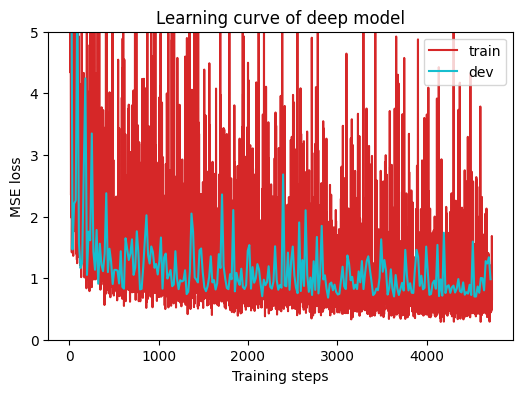

In [35]:
plot_learning_curve(model_loss_record, title='deep model')

In [36]:
from sklearn.model_selection import KFold

# Cross-Validation Function
def cross_validation(train_set, model_class, config, device, k=5):
    ''' Perform k-fold cross-validation '''
    kfold = KFold(n_splits=k, shuffle=True, random_state=myseed)
    results = []

    data = train_set.dataset.data.numpy()
    target = train_set.dataset.target.numpy()

    for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
        print(f'Fold {fold + 1}/{k}')
        
        # Split data
        train_data, train_target = data[train_idx], target[train_idx]
        val_data, val_target = data[val_idx], target[val_idx]

        # Convert data to torch tensors
        train_data = torch.FloatTensor(train_data)
        train_target = torch.FloatTensor(train_target)
        val_data = torch.FloatTensor(val_data)
        val_target = torch.FloatTensor(val_target)

        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(train_data, train_target)
        val_dataset = torch.utils.data.TensorDataset(val_data, val_target)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

        # Initialize model and optimizer
        model = model_class(train_data.shape[1]).to(device)
        optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas']
        )

        # Train the model
        model_loss, model_loss_record = train(train_loader, val_loader, model, config, device)
        results.append(model_loss)

    avg_loss = sum(results) / len(results)
    print(f'Average validation loss after {k}-fold cross-validation: {avg_loss}')
    return avg_loss

# Perform k-fold cross-validation
cross_validation(train_set, NeuralNet, config, device, k=5)

Fold 1/5
Saving model (epoch =    1, loss = 23.9201)
Saving model (epoch =    2, loss = 3.9083)
Saving model (epoch =    3, loss = 3.7122)
Saving model (epoch =    5, loss = 2.6803)
Saving model (epoch =    7, loss = 2.6521)
Saving model (epoch =    9, loss = 2.3302)
Saving model (epoch =   11, loss = 1.5482)
Saving model (epoch =   12, loss = 1.3375)
Saving model (epoch =   30, loss = 1.2157)
Saving model (epoch =   42, loss = 1.1893)
Saving model (epoch =   57, loss = 1.1308)
Saving model (epoch =   64, loss = 1.1257)
Saving model (epoch =   74, loss = 1.0457)
Saving model (epoch =   98, loss = 0.9935)
Saving model (epoch =  102, loss = 0.9258)
Saving model (epoch =  167, loss = 0.9040)
Finished training after 268 epochs
Fold 2/5
Saving model (epoch =    1, loss = 13.1707)
Saving model (epoch =    2, loss = 10.7948)
Saving model (epoch =    3, loss = 9.2129)
Saving model (epoch =    4, loss = 3.9425)
Saving model (epoch =    5, loss = 2.2987)
Saving model (epoch =    7, loss = 2.0107

0.8889219244321186

In [37]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(test_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'prediction.csv')         # save prediction file to pred.csv

Saving results to prediction.csv


In [38]:
import pandas as pd
df_pred = pd.read_csv('prediction.csv')
df_pred.head(10)

,id,tested_positive
0,0,20.713150
1,1,21.109436
2,2,21.265572
3,3,21.019940
4,4,20.111996
5,5,20.099892
6,6,21.016998
7,7,20.326221
8,8,20.006397
9,9,20.921364


In [40]:
import os

df_pred.to_csv('/kaggle/working/prediction.csv', index=False)